In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from glob import glob
import PIL
from sklearn.metrics import confusion_matrix
import keras
# from keras.utils.np_utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten,Conv2D,MaxPool2D,BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample


import PIL
from PIL import Image as pilimg

import cv2

In [2]:
metadata = pd.read_csv("./Dataset/HAM10000_metadata.csv")
metadata = metadata[['image_id', 'dx']].rename({'image_id':'imgid' , 'dx' :'class'})

In [3]:
metadata.rename({'image_id': 'image_id', 'dx': 'class'}, axis=1, inplace=True)
metadata.head()

,image_id,class
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


In [4]:
metadata['class'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: class, dtype: int64

In [5]:
le = LabelEncoder()
metadata['class'] = le.fit_transform(metadata['class'])

In [6]:
df1 = metadata[metadata['class']==0]
df2 = metadata[metadata['class']==1]
df3 = metadata[metadata['class']==2]
df4 = metadata[metadata['class']==3]
df5 = metadata[metadata['class']==4]
df6 = metadata[metadata['class']==5]
df7 = metadata[metadata['class']==6]

In [7]:
samples = 1000
df1_balanced = resample(df1,replace = True,n_samples = samples,random_state = 2)
df2_balanced = resample(df2,replace = True,n_samples = samples,random_state = 2)
df3_balanced = resample(df3,replace = True,n_samples = samples,random_state = 2)
df4_balanced = resample(df4,replace = True,n_samples = samples,random_state = 2)
df5_balanced = resample(df5,replace = True,n_samples = samples,random_state = 2)
df6_balanced = resample(df6,replace = True,n_samples = samples,random_state = 2)
df7_balanced = resample(df7,replace = True,n_samples = samples,random_state = 2)

In [8]:
merged = pd.concat([df1_balanced,df2_balanced,df3_balanced,
                  df4_balanced,df5_balanced,df6_balanced,df7_balanced])

In [9]:
dir = "./Dataset/Skin Cancer/Skin Cancer"
id = [x.split('.')[0] for x in os.listdir(dir)]
image_path = {x:os.path.join(dir,f'{x}.jpg') for x in id}
merged['path'] = merged['image_id'].map(image_path.get)

In [10]:
merged.head(1)

,image_id,class,path
9855,ISIC_0029851,0,./Dataset/Skin Cancer/Skin Cancer\ISIC_0029851...


In [11]:
sample = {}
numpy_horizontal = []
limit = 0
for index, row in merged.iterrows():
    limit +=1
    if limit==10:
        break
    pth =row['path']
    cl = row['class']
    print(pth)
    image = np.asarray(pilimg.open(pth).resize((224,224)))
    
#     print(image.shape)
    if len(numpy_horizontal)==0:
        numpy_horizontal = np.hstack((image, image))
    
    else:
        numpy_horizontal = np.hstack((numpy_horizontal, image))


./Dataset/Skin Cancer/Skin Cancer\ISIC_0029851.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0027795.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0030827.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0030242.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0028517.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0026729.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0028763.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0032356.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0029860.jpg


(100, 1000, 3)


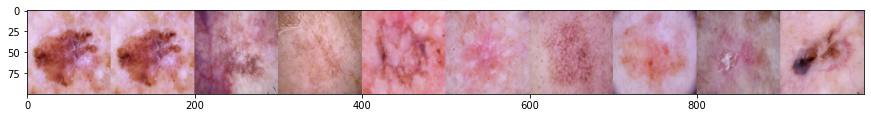

In [12]:

x = cv2.resize(numpy_horizontal,(1000, 100))
print(x.shape)
plt.figure(figsize=(15,8))
plt.imshow(x)

# Resnet 34 Arc (PYTORCH)

In [13]:
import torch
from torchvision import datasets, transforms
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensor

import numpy as np

import torch.nn as nn
import torch.nn.functional as F

In [14]:

class Args:

    # Data Loading
    # ============

    train_batch_size = 64
    val_batch_size = 64
    num_workers = 4

    # Augmentation
    # ============
    horizontal_flip_prob = 0.2
    vertical_flip_prob = 0.0
    gaussian_blur_prob = 0.0
    rotate_degree = 20
    cutout = 0.3

    # Training
    # ========
    random_seed = 1
    epochs = 50
    learning_rate = 0.01
    momentum = 0.9
    lr_step_size = 5
    lr_gamma = 0.15

    # Evaluation
    # ==========
    sample_count = 25




class Transforms:
    

    def __init__(self, train = True,  **transform_args):
        
        
        ## ARGS
        
        horizontal_flip_prob = transform_args['horizontal_flip_prob']
        vertical_flip_prob = transform_args['vertical_flip_prob']
        gaussian_blur_prob = transform_args['gaussian_blur_prob']
        rotate_degree = transform_args['rotate_degree']
        cutout = transform_args['cutout']
        cutout_height = transform_args['cutout_height']
        cutout_width = transform_args['cutout_width'] 
    
        
        mean=(0.5, 0.5, 0.5)
        std=(0.5, 0.5, 0.5)
        
        # Train phase transformations
         
        transforms_list = []
    
        if train:
            if horizontal_flip_prob > 0:  # Horizontal Flip
                transforms_list += [A.HorizontalFlip(p=horizontal_flip_prob)]
            if vertical_flip_prob > 0:  # Vertical Flip
                transforms_list += [A.VerticalFlip(p=vertical_flip_prob)]
            if gaussian_blur_prob > 0:  # Patch Gaussian Augmentation
                transforms_list += [A.GaussianBlur(p=gaussian_blur_prob)]
            if rotate_degree > 0:  # Rotate image
                transforms_list += [A.Rotate(limit=rotate_degree)]
            if cutout > 0:  # CutOut
                transforms_list += [A.CoarseDropout(
                    p=cutout, max_holes=1, fill_value=tuple([x * 255.0 for x in mean]),
                    max_height=cutout_height, max_width=cutout_width, min_height=1, min_width=1
                )]
            transforms_list +=[A.augmentations.transforms.ColorJitter(brightness=0.2, contrast=0.2, \
                                                                     saturation=0.2, hue=0.2, always_apply=False, p=0.2)]
            pass


        transforms_list += [
            # normalize the data with mean and standard deviation to keep values in range [-1, 1]
            # since there are 3 channels for each image,
            # we have to specify mean and std for each channel
            A.Normalize(mean=mean, std=std, always_apply=True),
            
            # convert the data to torch.FloatTensor
            # with values within the range [0.0 ,1.0]
            ToTensor()
        ]
    
    
        self.transform =  A.Compose(transforms_list)    

    def __call__(self, image):
        """Process and image through the data transformation pipeline.

        Args:
            image: Image to process.
        
        Returns:
            Transformed image.
        """

        image = np.array(image)
        image = self.transform(image=image)['image']
        return image


In [15]:
train_met, test_met = train_test_split(merged, test_size = 0.2, shuffle=True)

In [16]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform = None):
        self.df = data
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
#         print('INDEX : ', index)
        image_path = self.df[['path']].iloc[index].item()
#         print('PAth : |||', image_path)
        image = np.asarray(pilimg.open(image_path).resize((64,64)))
        label = self.df[['class']].iloc[index].item()
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [17]:
train_met.head(2)

,image_id,class,path
9745,ISIC_0032455,0,./Dataset/Skin Cancer/Skin Cancer\ISIC_0032455...
2445,ISIC_0031955,6,./Dataset/Skin Cancer/Skin Cancer\ISIC_0031955...


In [18]:
train_met[['path']].iloc[1].item()

'./Dataset/Skin Cancer/Skin Cancer\\ISIC_0031955.jpg'

In [19]:
transform_args = {}

transform_args['horizontal_flip_prob'] =  Args.horizontal_flip_prob
transform_args['vertical_flip_prob'] = Args.vertical_flip_prob
transform_args['gaussian_blur_prob'] = Args.gaussian_blur_prob
transform_args['rotate_degree'] = Args.rotate_degree
transform_args['cutout'] = 0.3
transform_args['cutout_height'] = 16
transform_args['cutout_width'] = 16


train_transforms = Transforms(train=True, **transform_args)
test_transforms = Transforms(train = False , **transform_args)  

train_dataset = CustomDataset(train_met, train_transforms )
test_dataset = CustomDataset(test_met, test_transforms)


image, label = train_dataset[0]

In [20]:
def get_device(force_cpu = True):
    
    if force_cpu:
        device = torch.device("cpu")
    
    else:
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")

    return device

device = get_device()

In [21]:
if device.type == 'cpu':
    cuda = False
else:
    cuda = True

dataloader_args = dict(shuffle=True, batch_size=Args.train_batch_size, num_workers=Args.num_workers, pin_memory=True) if cuda else dict(shuffle=True, batch_size=Args.train_batch_size)


train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

## MODEL

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# from model2 import ResNet18
from torchsummary import summary

### In deep learning context, the Receptive Field (RF) is defined as the size of the region in the input that produces the feature. Basically, it is a measure of association of an output feature (of any layer) to the input region (patch)

In [23]:
from Resnet.resnet import ResNet,BasicBlock
model = ResNet(BasicBlock, [3, 4, 6, 3],7 ,8).to(device)

In [24]:
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          36,864
      BatchNorm2d-14           [-1, 64,

In [25]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan  8 15:38:57 2021

@author: saina
"""


import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# from model import Net


def train(model, train_loader, criterion, optimizer, device, l1_factor =0,  **trackers):
      
    model.train()
    correct_classified = 0
    for batch_number , (x_train,y_train) in enumerate(train_loader):
        
        batch_number+=1
        
        x_train,y_train = x_train.to(device), y_train.to(device)

        # print(x_train.shape)
        pred = model.forward(x_train)

        # print(pred.shape)
        # print(y_train.shape)
        loss = criterion(pred,y_train)
        
        ## L1 LOSS
        if l1_factor > 0:  # Apply L1 regularization
            l1_criteria = nn.L1Loss(size_average=False)
            regularizer_loss = 0
            for parameter in model.parameters():
                regularizer_loss += l1_criteria(parameter, torch.zeros_like(parameter))
            loss += l1_factor * regularizer_loss
        
        #pred.argmax(dim=1, keepdim=True)
        #PyTorch .eq() function to do this, which compares the values in two tensors and if they match, returns a 1. If they don’t match, it returns a 0:
        #correct += pred.eq(target.view_as(pred)).sum().item()
        predicted = torch.max(pred.data ,1)[1]
        correct_classified += (predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # train_loader.dataset.data / train_loader.batch_size
        
        if batch_number%100 == 0:
            
            acc = round((correct_classified.item())/(batch_number*train_loader.batch_size),5)
            print(f'(TRAIN) batch_number: {batch_number:4} Loss : {loss:4.4} Acc : {acc:4.5}')
    
    acc = round((correct_classified.item())/len(train_loader.dataset),5)
    
    prev_acc = trackers['train_acc']
    trackers['train_acc'] = prev_acc.append(acc)
    
    prev_losses = trackers['train_losses']
    trackers['train_losses'] = prev_losses.append(loss.item())  






def test(model, test_loader, criterion, device, incorrect_samples, **trackers):
    
    test_losses = []
    
    model.eval()
    with torch.no_grad():
        
        correct_classified = 0
        for batch_number , (x_test,y_test) in enumerate(test_loader):
        
            x_test,y_test = x_test.to(device), y_test.to(device)
            pred = model.forward(x_test)
            loss = criterion(pred,y_test)
            test_losses.append(loss)
            
            correct_classified += (torch.max(pred,1)[1] == y_test).sum()
            
            ## INCORRECT PRED SAMPLES !
            output = pred.argmax(dim=1, keepdim=True)
            result = output.eq(y_test.view_as(output))
        
            if len(incorrect_samples) < 25:
                for i in range(test_loader.batch_size):
                    if not list(result)[i]:
                        incorrect_samples.append({
                            'prediction': list(output)[i],
                            'label': list(y_test.view_as(output))[i],
                            'image': list(x_test)[i]
                        }) 
    
        avg_loss = torch.mean(torch.tensor(test_losses))
        acc = round(correct_classified.item()/len(test_loader.dataset),5)
        
        prev_acc = trackers['test_acc']
        trackers['test_acc'] = prev_acc.append(acc)
        
        prev_losses = trackers['test_losses']
        trackers['test_losses'] = prev_losses.append(avg_loss.item())  
        
        print('(TEST) Correct_classified : ' , correct_classified.item() ,' of ' , len(test_loader.dataset))
        print(f'(TEST) Loss : {avg_loss:4.4} Acc : {acc:4.5}')
        print('\n','*'*60 , '\n')
        

     
        
     
        
        
def run_model(model, train_loader, test_loader, epochs, device, **regularization):
        
    # model = Net().to(device)
    
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    l2_factor = regularization['l2_factor']
    l1_factor = regularization['l1_factor']
    
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=l2_factor)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.15)
    
    ## TRACKERS
    train_losses = []
    train_acc = []
    train_trackers = {'train_acc':train_acc,'train_losses':train_losses}
    
    test_acc = []
    test_losses = []
    test_trackers = {'test_acc':test_acc,'test_losses':test_losses}
    
    incorrect_samples = []
    
    ## Model RUN!
    for epoch in range(1, epochs + 1):
        print(f'\nEpoch {epoch}:')
        train(model,train_loader, criterion, optimizer, device,l1_factor =l1_factor, **train_trackers)
        scheduler.step()
        test(model, test_loader, criterion, device, incorrect_samples, **test_trackers)
        
    return model,train_trackers,test_trackers,incorrect_samples

        

In [26]:
epochs = 15
regularization = {'l1_factor':0,'l2_factor':0}

model,train_trackers,test_trackers,incorrect_samples = run_model(model, train_loader, test_loader, epochs, device, **regularization)


Epoch 1:
(TEST) Correct_classified :  469  of  1400
(TEST) Loss : 1.582 Acc : 0.335

 ************************************************************ 


Epoch 2:
(TEST) Correct_classified :  647  of  1400
(TEST) Loss : 1.338 Acc : 0.46214

 ************************************************************ 


Epoch 3:
(TEST) Correct_classified :  734  of  1400
(TEST) Loss : 1.286 Acc : 0.52429

 ************************************************************ 


Epoch 4:
(TEST) Correct_classified :  726  of  1400
(TEST) Loss : 1.265 Acc : 0.51857

 ************************************************************ 


Epoch 5:
(TEST) Correct_classified :  720  of  1400
(TEST) Loss : 1.269 Acc : 0.51429

 ************************************************************ 


Epoch 6:
(TEST) Correct_classified :  977  of  1400
(TEST) Loss : 0.77 Acc : 0.69786

 ************************************************************ 


Epoch 7:
(TEST) Correct_classified :  1052  of  1400
(TEST) Loss : 0.64 Acc : 0.75143

 **

In [41]:
torch.save(model.state_dict() ,'C:\\Users\\saina\\Documents\\Assignements\\Dissertation\\Saved Models\\res34_trained_15best_sample.pt') 

In [34]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

categories = {v: k for k, v in le_name_mapping.items()}
categories

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}

<AxesSubplot:>

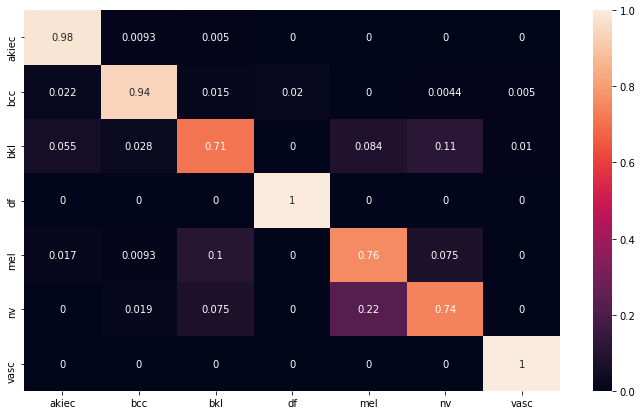

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = le.classes_

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [27]:
epochs = 15
regularization = {'l1_factor':0,'l2_factor':0}

model,train_trackers,test_trackers,incorrect_samples = run_model(model, train_loader, test_loader, epochs, device, **regularization)


Epoch 1:
(TEST) Correct_classified :  651  of  1400
(TEST) Loss : 1.367 Acc : 0.465

 ************************************************************ 


Epoch 2:
(TEST) Correct_classified :  713  of  1400
(TEST) Loss : 1.234 Acc : 0.50929

 ************************************************************ 


Epoch 3:
(TEST) Correct_classified :  741  of  1400
(TEST) Loss : 1.285 Acc : 0.52929

 ************************************************************ 


Epoch 4:
(TEST) Correct_classified :  732  of  1400
(TEST) Loss : 1.175 Acc : 0.52286

 ************************************************************ 


Epoch 5:
(TEST) Correct_classified :  918  of  1400
(TEST) Loss : 0.8928 Acc : 0.65571

 ************************************************************ 


Epoch 6:
(TEST) Correct_classified :  1025  of  1400
(TEST) Loss : 0.7157 Acc : 0.73214

 ************************************************************ 


Epoch 7:
(TEST) Correct_classified :  1057  of  1400
(TEST) Loss : 0.6468 Acc : 0.755


In [28]:
torch.save(model.state_dict() ,'C:\\Users\\saina\\Documents\\Assignements\\Dissertation\\Saved Models\\res34_trained_15eh_sample.pt') 

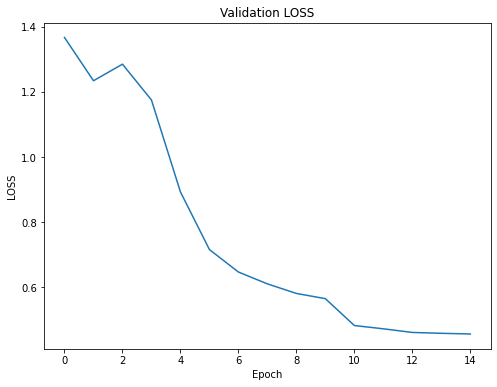

In [29]:
## loss graphs

metric = 'LOSS'
# Initialize a figure
fig = plt.figure(figsize=(8, 6))

# Plot values
plain_plt, = plt.plot(test_trackers['test_losses'])


# Set plot title
plt.title(f'Validation {metric}')

# Label axes
plt.xlabel('Epoch')
plt.ylabel(metric)

# Set legend
location = 'upper' if metric == 'Loss' else 'lower'

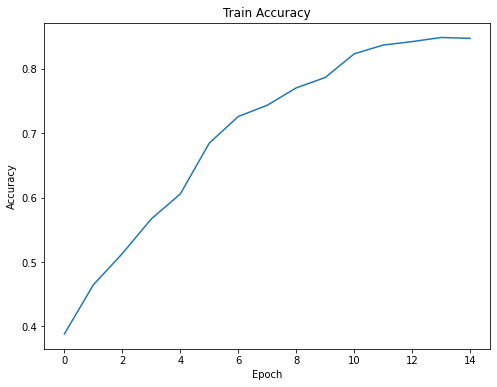

In [30]:
## loss graphs

metric = 'Accuracy'
# Initialize a figure
fig = plt.figure(figsize=(8, 6))

# Plot values
plain_plt, = plt.plot(train_trackers['train_acc'])


# Set plot title
plt.title(f'Train {metric}')

# Label axes
plt.xlabel('Epoch')
plt.ylabel(metric)

# Set legend
location = 'upper' if metric == 'Loss' else 'lower'

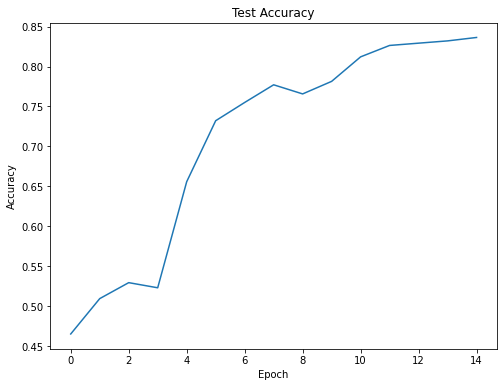

In [31]:
## loss graphs

metric = 'Accuracy'
# Initialize a figure
fig = plt.figure(figsize=(8, 6))

# Plot values
plain_plt, = plt.plot(test_trackers['test_acc'])


# Set plot title
plt.title(f'Test {metric}')

# Label axes
plt.xlabel('Epoch')
plt.ylabel(metric)

# Set legend
location = 'upper' if metric == 'Loss' else 'lower'

## GRADCAM

In [103]:
list(model.children())

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (shortcut): Sequential()
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (shortcut)

## GRAD CAM TEST DATA 

In [139]:
class CustomDataset2(torch.utils.data.Dataset):
    def __init__(self, data, transform = None):
        self.df = data
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        image_path = self.df[['path']].iloc[index].item()
        image = np.asarray(pilimg.open(image_path).resize((64,64)))
        label = self.df[['class']].iloc[index].item()
        return image, label
    
test_dataset2 = CustomDataset2(test_met)

In [152]:
# from data import Transforms
from torchvision import datasets
sample_loader = torch.utils.data.DataLoader(test_dataset2, batch_size = 1, shuffle=False, num_workers=0, persistent_workers=False)

In [195]:
for image,label in sample_loader:
    break

In [196]:
image.shape, label

(torch.Size([1, 64, 64, 3]), tensor([0]))

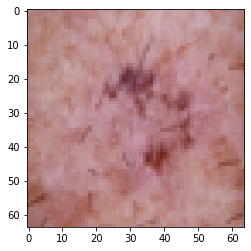

In [197]:
img1 = image[0]
plt.imshow(img1)

In [211]:
mean=(0.5, 0.5, 0.5)
std=(0.5, 0.5, 0.5)
transforms_list = [A.Normalize(mean=mean, std=std, always_apply=True),ToTensor()]

transform =  A.Compose(transforms_list)    

image = np.array(image)
image = transform(image=image)['image']
image = image.reshape(1,3,64,64)

In [213]:
# img1 = np.transpose(image[0].squeeze().cpu().data.numpy(), (1,2,0))
# img1 = img1[...,::-1]
# plt.imshow( img1)

In [1]:
class ModelGradCam(nn.Module):
    
    def __init__(self, model):
        super().__init__()
        
        # get the pretrained resnet network
        self.res = model
        
        # disect the network to access its last convolutional layer
        self.features_conv = nn.Sequential(*list(self.res.children())[:-2])
        
        # # get the max pool of the features stem
        # self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the resnet
        self.classifier1 = list(self.res.children())[-2:][0]
        self.classifier2 = list(self.res.children())[-2:][1]

        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        # register the hook
        h = x.register_hook(self.activations_hook)

        # apply the remaining pooling
        x = self.classifier1(x)
        x = F.avg_pool2d(x, 8)
        x = x.view(x.size(0), -1)
        x = self.classifier2(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

NameError: name 'nn' is not defined

In [215]:
def get_gradcamout(ModelGradCam, model, image):
    # initialize the resnet model
    res = ModelGradCam(model)
    # set the evaluation mode
    res.eval()
    # get the most likely prediction of the model
    pred = res(image)

    # get the gradient of the output with respect to the parameters of the model
    pred_idx = pred.argmax(dim=1)
    pred[:, pred_idx].backward()
    gradients = res.get_activations_gradient()
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    # get the activations of the last convolutional layer
    activations = res.get_activations(image).detach()

    # weight the channels by corresponding gradients
    for i in range(256):
        activations[:, i, :, :] *= pooled_gradients[i]

    # weight the channels by corresponding gradients
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap.shape

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap.cpu(), 0)
    heatmap.shape

    heatmap /= torch.max(heatmap)

    # normalize the heatmap
    # plt.matshow(heatmap.squeeze())

    heatmap_numpy_resized = cv2.resize(heatmap.cpu().data.numpy(), (600, 450))
    heatmap_rescaled = np.uint8(255 * heatmap_numpy_resized)

    # plt.imshow(heatmap_rescaled)
    return heatmap_rescaled

(100, 1000, 3)


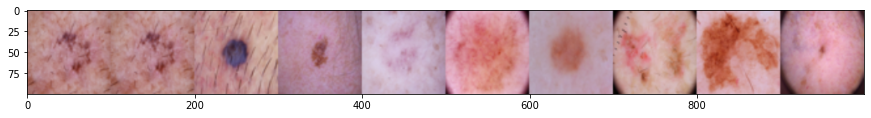

In [216]:
sample = {}
numpy_horizontal = []
limit = 0

grad_out = []

for image,label in sample_loader:
    limit +=1
    if limit==10:
        break
        
    image2 = image.reshape(64,64,3)
        
    mean=(0.5, 0.5, 0.5)
    std=(0.5, 0.5, 0.5)
    transforms_list = [A.Normalize(mean=mean, std=std, always_apply=True),ToTensor()]

    transform =  A.Compose(transforms_list)    

    image = np.array(image)
    image = transform(image=image)['image']
    image = image.reshape(1,3,64,64)
    hm = get_gradcamout(ModelGradCam, model, image)
        
    if len(grad_out)==0:
        grad_out = np.hstack((hm, hm))
    else:
        grad_out = np.hstack((grad_out, hm))    
    
    if len(numpy_horizontal)==0:
        numpy_horizontal = np.hstack((image2, image2))
    else:
        numpy_horizontal = np.hstack((numpy_horizontal, image2))

x = cv2.resize(numpy_horizontal,(1000, 100))
print(x.shape)
plt.figure(figsize=(15,8))
plt.imshow(x)

(100, 1000)


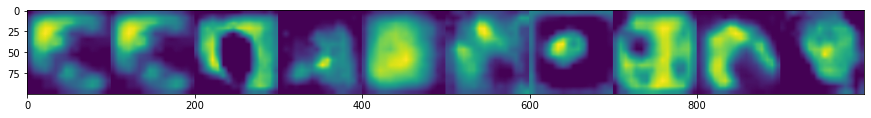

In [217]:
y = cv2.resize(grad_out,(1000, 100))
print(y.shape)
plt.figure(figsize=(15,8))
plt.imshow(y)

In [190]:
# initialize the resnet model
res = ModelGradCam(model)
# set the evaluation mode
res.eval()
# get the most likely prediction of the model
pred = res(image)

HERE0 torch.Size([1, 256, 16, 16])
HERE1 torch.Size([1, 512, 8, 8])
HERE2 torch.Size([1, 512])


In [191]:
pred

tensor([[ 1.2011,  2.9554, -0.5743,  2.2807, -2.9721, -2.0249, -0.0604]],
       grad_fn=<AddmmBackward0>)

In [192]:
# get the gradient of the output with respect to the parameters of the model
pred_idx = pred.argmax(dim=1)
pred[:, pred_idx].backward()
gradients = res.get_activations_gradient()
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
# get the activations of the last convolutional layer
activations = res.get_activations(image).detach()

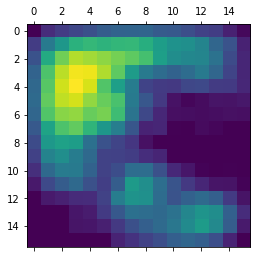

In [193]:
# weight the channels by corresponding gradients

for i in range(256):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# weight the channels by corresponding gradients

heatmap = torch.mean(activations, dim=1).squeeze()
heatmap.shape


# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap.cpu(), 0)
heatmap.shape

heatmap /= torch.max(heatmap)

# normalize the heatmap
plt.matshow(heatmap.squeeze())

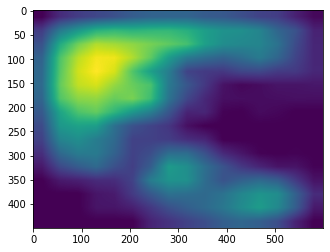

In [194]:
heatmap_numpy_resized = cv2.resize(heatmap.cpu().data.numpy(), (600, 450))
heatmap_rescaled = np.uint8(255 * heatmap_numpy_resized)

plt.imshow(heatmap_rescaled)